**CV2021 - week8**

In [1]:
import numpy as np
import cv2 as cv
import os
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from pyefd import elliptic_fourier_descriptors



In [2]:
def load_dataset(dset_dir):
  # a dict to keep the class of each image
  image_index = {}

  for class_name in os.listdir(dset_dir):
    in_cat_images = []
    cat_dir_path = "{}/{}".format(dset_dir, class_name)
    for file_name in os.listdir(cat_dir_path):
      img_path = "{}/{}".format(cat_dir_path, file_name)
      img = cv.imread(img_path, 0) # open as grayscale
      if img is not None: # unless some corrupted images
        in_cat_images.append(img)
    image_index[class_name] = in_cat_images
  
  return image_index

# iterates over the image dict and returns the raw vocabulary 
# and the vocabulary characteristic to each of the classes
def extract_features(img_dict):
  sift_descriptors = {}
  vocabulary = []

  sift = cv.SIFT_create()
  
  for img_class, img_list in img_dict.items():
    features = []
    for image in img_list:
      kp, des = sift.detectAndCompute(image, None)
      vocabulary.extend(des)
      features.append(des)
    
    # take care also for the in class vocabulary
    sift_descriptors[img_class] = features
  
  return vocabulary, sift_descriptors


# k - an integer representing the number of representative words
# vocabulary - a list of the features extracted across the train dset
def knn_refine_vocab(k, vocabulary):
  kmeans = KMeans(n_clusters=k, n_init=10)
  kmeans.fit(vocabulary)
  # return the visual words as the centroids of the clustered data
  v_words = kmeans.cluster_centers_
  return v_words


# finds the closest centroid
def find_index(feat, visual_words):
  dist_min = 0
  ind_min = 0
  dist_min = distance.euclidean(feat, visual_words[0]) 
  for i in range(1, len(visual_words)):
    dist = distance.euclidean(feat, visual_words[i]) 
    if dist < dist_min:
      ind_min = i
      dist_min = dist
  return ind_min


# uses the class sift descriptors dict and the centroids list 
# as visual words
def create_bag_of_words(sift_descriptors, v_words):
  dict_bovw = {}
  for img_class, feat_list in sift_descriptors.items():
    in_cat_feats = []
    # for each image sift returns a list of descriptors
    for feat_set in feat_list:
      histogram = np.zeros(len(v_words))
      for descriptor in feat_set:
        index = find_index(descriptor, v_words)
        histogram[index] += 1
      in_cat_feats.append(histogram)

    dict_bovw[img_class] = in_cat_feats
  
  return dict_bovw

# predict class of a test image histogram, using 1nn
def knn_predict_class(train_feats, test_feats):
  # keep information regarding each class accuracy
  class_stat = {}
  idx_test = 0
  correct = 0

  for test_class, test_descrip in test_feats.items():
    class_stat[test_class] = [0, 0] # tuple would be immutable
    for tst_des in test_descrip:
      minim = 1e6
      key = None
      for train_class, train_descrip in train_feats.items():
        for trn_des in train_descrip:
          dist = distance.euclidean(tst_des, trn_des)
          if key is None:
            # initialize with the first distance
            minim = dist
            key = train_class
          else:
            if dist < minim:
              minim = dist
              key = train_class
       
      if key == test_class:
        correct += 1
        class_stat[test_class][0] += 1 # update correct
      
      idx_test += 1
      class_stat[test_class][1] += 1 # update total

  return idx_test, correct, class_stat



def evaluate_model(result_log):
  acc = result_log[1] / result_log[0] * 100
  print("Total accuracy: {}%".format(acc))

  for class_key, class_stat in result_log[2].items():
    acc = class_stat[0] / class_stat[1] * 100
    print("Accuracy for class \"{}\": {}%".format(class_key, acc))


In [3]:

# extracting and EFD feature should be done in 2 steps
# Coutours are to be detected, and then EFD is applied on contours
def extract_efd_feature(img):
  contours, _ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  fd = []
  for cnt in contours:
    coeffs = elliptic_fourier_descriptors(np.squeeze(cnt), order=10, normalize=True)
    fd.append(coeffs.flatten()[3:])
  return np.array(fd)


def prepare_data(image_set):
  X = []
  Y = []
  for img_class, img_list in image_set.items():
    for image in img_list:
      try:
        fdesc = extract_efd_feature(image)
        X.append(np.max(fdesc, axis=0)) # pooling strategy here (task 3)
        Y.append(int(img_class))
      except np.AxisError:
        continue # some corrupted images

  return np.array(X), np.array(Y)

In [26]:
train_img = load_dataset("./mnist_binary/train/")
test_img = load_dataset("./mnist_binary/test/")

In [34]:
train_img = load_dataset("./mnist_png_even_odd/train/")
test_img = load_dataset("./mnist_png_even_odd/test/")

In [35]:

X_train, Y_train = prepare_data(train_img)
X_test, Y_test = prepare_data(test_img)
print(X_train.shape)
print(Y_train.shape)


(1269, 37)
(1269,)


**4. Adaboost**


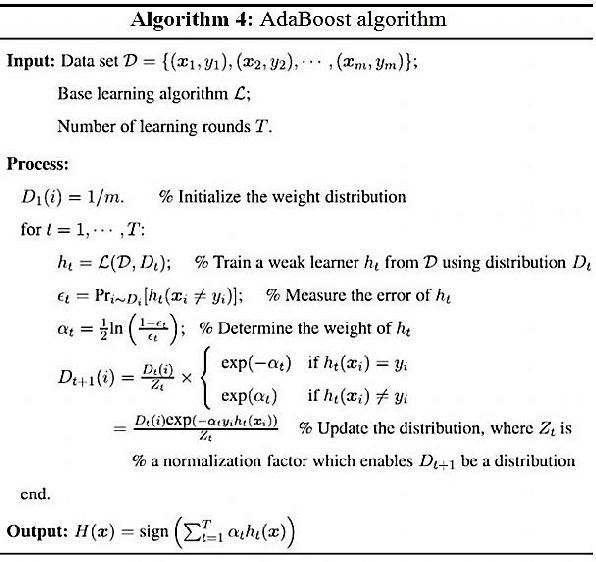

**Reference**
 * [Scikit Adaboost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)


* **2bp** Using the Adaboost pseudocode, propose your own Adaboost implementation for binary classification. Use a *scikit* *DecisionTree* as your base classifier, updating the set of per-sample weights at each iteration. Compare the classification accuracy with a single *DecisionTree* classifier, and a *RandomForest* of 10 estimators. Use the EFD data extracted for the third demo as your dataset.\


[Reference implementation](https://anujkatiyal.com/blog/2017/10/24/ml-adaboost/)

In [46]:
class AdaBoost(object):

    def __init__(self, learning_rounds,learner=None):
        self.X_train = None
        self.y_train = None
        self.M = None
        if learner:
            self.base_learner = learner
        else:
            self.base_learner = DecisionTreeClassifier(max_depth=1)
        self.learning_rounds = learning_rounds
        self.weights = None
        self.alphas = []
        self.classifiers = []
        
    def fit(self,X_train, y_train):
        self.alphas = []
        self.classifiers = []
        self.weights = []
        self.X_train = X_train
        self.y_train = y_train
        self.M = self.X_train.shape[0]

        self.weights = np.ones(self.M)/self.M
        for t in range(self.learning_rounds):

            output = np.random.choice(self.M, self.M, p=self.weights)
            B_Xtrain = self.X_train[output]
            B_ytrain = self.y_train[output]
            self.base_learner.fit(B_Xtrain, B_ytrain)
            
            Y_pred = self.base_learner.predict(self.X_train)

            e_t = np.sum((Y_pred != self.y_train) * self.weights)


            alpha_t = 0.5 * np.log((1 - e_t)/e_t)

            self.alphas.append(alpha_t)
            self.classifiers.append(self.base_learner)
            
            self.weights = self.weights * np.exp(-alpha_t* Y_pred * self.y_train)
            self.weights = self.weights / np.sum(self.weights)

    def predict(self, X):
        sum_ = np.zeros(X.shape[0])
        for i in range(self.learning_rounds):
            sum_ += (self.alphas[i] * self.classifiers[i].predict(X))
        fboost_pred = np.sign(sum_)
        return fboost_pred

In [52]:
boost = AdaBoost(2)
boost.fit(X_train, Y_train)
y_pred = boost.predict(X_test)
print()
print(accuracy_score(Y_test, y_pred))


0.685


In [53]:
dec_tree = DecisionTreeClassifier(max_depth=1).fit(X_train, Y_train)
y_pred_dectree = dec_tree.predict(X_test)
accuracy_score(Y_test, y_pred_dectree)


0.775

In [39]:
rf = RandomForestClassifier(n_estimators=10).fit(X_train, Y_train)
y_pred_rf = rf.predict(X_test)
accuracy_score(Y_test, y_pred_rf)

0.905